### Least Squares Method

![](http://bigsec.net/b52/scipydoc/_images/math/8da054a2d9fb73326f9fc0a3141cea13d49db11f.png.pagespeed.ce.jjnL4jkq6Z.png)

Assume we have a group of data x[i] and y[i], and we know their relationship y=f(x). Based on these information we need to know the parameters in f(x). For example, if f is a linear function f(x)=kx+b, then we need to know coefficients k and b. If we represent these coefficients with p, then we need to find a group of p values (p = [k,b]) so that S(p) reaches the minimum. 

In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

In [2]:
def func(x,p):
    """
    Expected Data
    """
    A, k, theta = p
    return A*np.sin(2*np.pi*k*x+theta)

In [3]:
def residuals(p,y,x):
    """
    Experiment data x, y
    Coefficient p
    """
    return y-func(x,p)

In [4]:
x = np.linspace(0,-2*np.pi,100)
A,k,theta = 10,0.34,np.pi/6       # Expected data coefficient
y0 = func(x,[A,k,theta])          # Expected data
y1 = y0+2*np.random.randn(len(x)) # Experimental data with noise

p0 = [7,0.2,0]   # First guess of coefficient

In [5]:
plsq = leastsq(residuals,p0,args=(y1,x))

print("Actual coefficients: ",[A,k,theta])
print("Computed coefficients: ",plsq[0])

Actual coefficients:  [10, 0.34, 0.5235987755982988]
Computed coefficients:  [-9.60686755  0.33975184  3.67278225]


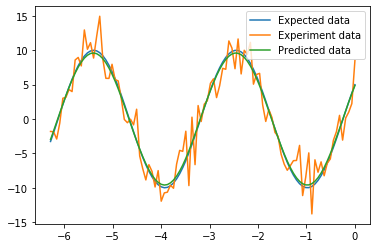

In [6]:
plt.plot(x,y0,label="Expected data")
plt.plot(x,y1,label="Experiment data")
plt.plot(x,func(x,plsq[0]),label="Predicted data")
plt.legend()
plt.show()

### Function minimum

The optimize library provides several algorithm to compute function minimum value: fmin, fmin_powell, fmin_cg, fmin_bfgs. 

For a system h, if the input is x, then the output can be represented by the convolution of x and h: y = x * h. Now if we know x and y, how do we compute the system transfer function h? Or if we know y and h, how do we know the input x? Such computation is called *Transposed convolution*. Yet in real application, measuring the system output always have errors. 

In [7]:
import scipy.optimize as opt

In [8]:
def test_fmin_convolve(fminfunc,x,h,y,yn,x0):
    """
    x*h=y, * means convolution
    yn is y with noise
    x0 is the initial value used to solve for x
    """
    def convolve_func(h):
        """
        compute the power of yn-x*h
        use fmin() to compute and make the power at the minimum
        """
        return np.sum((yn-np.convolve(x,h))**2)
    # use x0 as the initial value in fmin function
    h0 = fminfunc(convolve_func,x0)
    
    print(fminfunc.__name__)
    print("---------------")
    # relative error between x*h0 and y
    print("error of y: ", np.sum((np.convolve(x,h0)-y)**2)/np.sum(y**2))
    # relative error between h0 and h
    print("error of h: ", np.sum((h0-h)**2)/np.sum(h**2))
    print()

In [9]:
def test_n(m, n, nscale):
    """
    generate random array x, h, y, yn, x0, and use different fmin() to solve for b
    m is the length of x, n is the length of h, nscale is noise scale
    """
    x = np.random.rand(m)
    h = np.random.rand(n)
    y = np.convolve(x,h)
    yn = y+np.random.rand(len(y))*nscale
    x0 = np.random.rand(n)
    
    test_fmin_convolve(opt.fmin,x,h,y,yn,x0)
    test_fmin_convolve(opt.fmin_powell,x,h,y,yn,x0)
    test_fmin_convolve(opt.fmin_cg,x,h,y,yn,x0)
    test_fmin_convolve(opt.fmin_bfgs,x,h,y,yn,x0)

In [10]:
if __name__ == "__main__":
    test_n(200,20,0.1)

fmin
---------------
error of y:  0.0007397965981953768
error of h:  0.03567419104113551

Optimization terminated successfully.
         Current function value: 0.201830
         Iterations: 46
         Function evaluations: 8527
fmin_powell
---------------
error of y:  9.402774276888645e-05
error of h:  0.00023657639779337913

Optimization terminated successfully.
         Current function value: 0.201829
         Iterations: 17
         Function evaluations: 748
         Gradient evaluations: 34
fmin_cg
---------------
error of y:  9.393955990371529e-05
error of h:  0.00023702769412357088

Optimization terminated successfully.
         Current function value: 0.201829
         Iterations: 31
         Function evaluations: 924
         Gradient evaluations: 42
fmin_bfgs
---------------
error of y:  9.39395717001481e-05
error of h:  0.0002370286634190981



### Nonlinear Equations

In the optimize library, the fsolve() function can be used to solve nonlinear equations, fsolve(func, x0). For example, let's solve this equation: 
```
5X1+3=0
4X0^2-2sin(X1*X2)=0
X1*X2-1.5=0
```

In [11]:
from scipy.optimize import fsolve
from math import sin, cos

In [12]:
def f(x):
    x0 = float(x[0])
    x1 = float(x[1])
    x2 = float(x[2])
    return [
       5*x1+3,
       4*x0*x0-2*sin(x1*x2),
       x1*x2-1.5
    ]

In [13]:
import time
t1 = time.time()
result = fsolve(f,[1,1,1])
t2 = time.time()
print(t2-t1)
print(result)
print(f(result))

0.0010013580322265625
[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


- **jacobian matrix**

![](http://bigsec.net/b52/scipydoc/_images/math/0e0589610ac2875dcd7d12db88259d4076bd8fe7.png.pagespeed.ce.xDlc6GLyz2.png)

In [14]:
def j(x):
    x0 = float(x[0])
    x1 = float(x[1])
    x2 = float(x[2])
    return [
        [0,5,0],
        [8*x0,-2*x2*cos(x1*x2),-2*x1*cos(x1*x2)],
        [0,x2,x1]
    ]

In [15]:
import time
t1 = time.time()
result = fsolve(f,[1,1,1])
t2 = time.time()
print(t2-t1)
result = fsolve(f,[1,1,1],fprime=j)
print(result)
print(f(result))

0.0
[-0.70622057 -0.6        -2.5       ]
[0.0, -9.126033262418787e-14, 5.329070518200751e-15]


### B-Spline

The interpolate library provides functions for linear interpolation. Here is an example using straight line and B-Spline to do linear interpolation on a sine wave.

In [16]:
from scipy import interpolate

In [17]:
x = np.linspace(0,2*np.pi+np.pi/4,10)
y = np.sin(x)

x_new = np.linspace(0,2*np.pi+np.pi/4,100)
f_linear = interpolate.interp1d(x,y)
tck = interpolate.splrep(x,y)
y_bspline = interpolate.splev(x_new,tck)

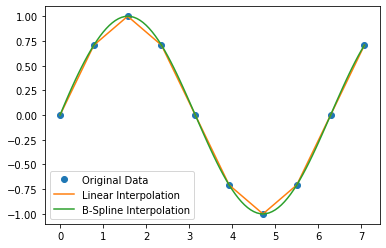

In [18]:
plt.plot(x,y,"o",label="Original Data")
plt.plot(x_new,f_linear(x_new),label="Linear Interpolation")
plt.plot(x_new,y_bspline,label="B-Spline Interpolation")
plt.legend()
plt.show()

### Numerical Integration

In [19]:
def half_circle(x):
    return (1-x**2)**0.5

In [20]:
N = 1000
x = np.linspace(-1,1,N)
dx = 2.0/N
y = half_circle(x)
print(dx*np.sum(y[:-1]+y[1:]))

3.138345831727239


In [21]:
print(np.trapz(y,x)*2)

3.141487319046285


In [22]:
from scipy import integrate
pi_half,err = integrate.quad(half_circle,-1,1)
print(pi_half*2)

3.1415926535897967


In [23]:
def half_sphere(x,y):
    return (1-x**2-y**2)**0.5

In [24]:
V = integrate.dblquad(half_sphere,-1,1,
                     lambda x: -half_circle(x),
                     lambda x: half_circle(x))
print(V)

(2.0943951023931984, 1.0002354500215915e-09)


In [25]:
print(np.pi*4/3/2)

2.0943951023931953


dblquad(func2d,a,b,gfun,hfun)

double integration on func2d(x,y) function, x on domain [a,b], and y on domain [gfun(x),hfun(x)]

### Ordinary Differential Equation

We use odeint() to solve ordinary differential equations. In this example, we use it to solve a [lorenz_attactor](http://bzhang.lamost.org/website/archives/lorenz_attactor). 

![](http://bigsec.net/b52/scipydoc/_images/math/a782b9635503dcc4bf75e540b7090ede53a36cfa.png.pagespeed.ce.iYEiaLO0jJ.png)
![](http://bigsec.net/b52/scipydoc/_images/math/ceef48a9a48807e014e3eac403cae178b058f1e6.png.pagespeed.ce.A8aflAk-aG.png)
![](http://bigsec.net/b52/scipydoc/_images/math/7faa9906de5c97c093fc70f4190d54ef69dfd4d9.png.pagespeed.ce.FoSz4t58ll.png)

In [26]:
from scipy.integrate import odeint

In [27]:
def lorenz(w,t,p,r,b):
    # position vector w 
    # compute dx/dt, dy/dt, dz/dt
    x,y,z = w
    # user lorenz equations
    return np.array([p*(y-x),x*(r-z)-y,x*y-b*z])

In [28]:
t = np.arange(0,30,0.01)
# solve lorenz ode using two different initial values
track1 = odeint(lorenz,(0.0,1.00,0.0),t,args=(10.0,28.0,3.0))
track2 = odeint(lorenz,(0.0,1.01,0.0),t,args=(10.0,28.0,3.0))

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

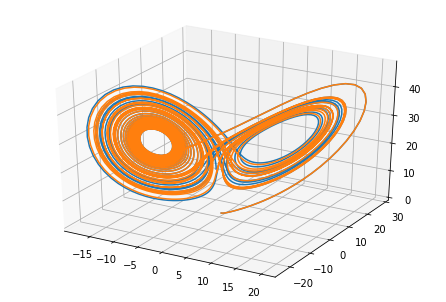

In [30]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(track1[:,0],track1[:,1],track1[:,2])
ax.plot(track2[:,0],track2[:,1],track2[:,2])
plt.show()

With a 0.01 error in the initial value, there is a big difference in the end of the plot, and this is what we call the "Butterfly Effect". 

### Filter Design

In [31]:
import scipy.signal as signal

Text(0.5, 1.0, 'freqz')

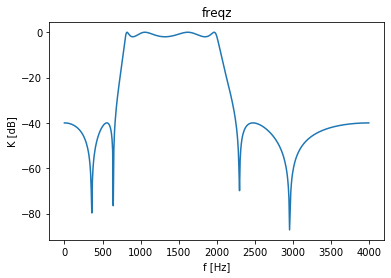

In [32]:
# IIR Filter
b,a = signal.iirdesign([0.2,0.5],[0.1,0.6],2,40)
# Frequency Response
w,h = signal.freqz(b,a)
# mag --> dB
power = 20*np.log10(np.clip(np.abs(h),1e-8,1e100))
plt.plot(w/np.pi*4000,power)
plt.ylabel("K [dB]")
plt.xlabel("f [Hz]")
plt.title("freqz")

Text(0.5, 1.0, 'frequency sweep')

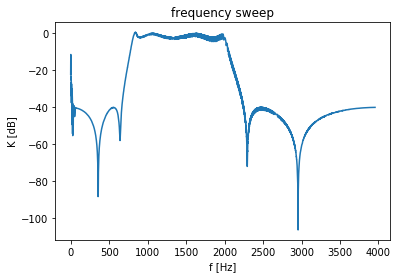

In [33]:
t = np.arange(0,2,1/8000.0)
sweep = signal.chirp(t,f0=0,t1=2,f1=4000.0)
out = signal.lfilter(b,a,sweep)
out = 20*np.log10(np.abs(out))
index = np.where(np.logical_and(out[1:-1]>out[:-2],out[1:-1]>out[2:]))[0]+1
plt.plot(t[index]/2.0*4000,out[index])
plt.ylabel("K [dB]")
plt.xlabel("f [Hz]")
plt.title("frequency sweep")

### Weave and C Language

Weave is no longer available in Python 3

![](http://wx2.sinaimg.cn/bmiddle/006m97Kggy1g5566x1j3pj30dc09w3yq.jpg)